In [1]:
# from kerasbeats import prep_multiple_time_series,prep_time_series,NBeatsModel
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, PLSRegression
from sklearn import metrics

import numpy as np 
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Flatten
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam, RMSprop


import math
from sklearn.metrics import mean_squared_error
from utils import eval_model

In [2]:
# test gpu
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-08-03 16:41:44.045522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 16:41:44.050950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 16:41:44.051923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
df = pd.read_csv('2005-2022-test.csv')
df =df.drop(columns=['FeatureFamily.MACRO.1'])
# df = pd.read_csv('2005-2022-pca10.csv')

In [4]:
df['date'] = pd.to_datetime(df.date)

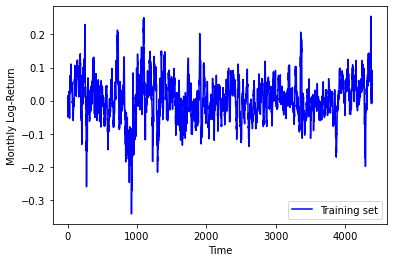

In [5]:

plt.plot(df['y'], color='blue', label='Training set')
plt.xlabel('Time')
plt.ylabel('Monthly Log-Return')
plt.legend()
plt.show()

### Create dataset for NN model  - One Split Framework

lookback window: [x1,x2,x3,x4, ... x65, x66] skip 21 datapoints [x67,x68, ...., x88]  -> forecast next one as label [x89]

In [6]:
lookback = 66
test_start_index = df[df.date >= '2018-05-01'].index[0] - lookback - 22
val_start_index = df[df.date >= '2016-05-01'].index[0] - lookback

train_df = df[df.date < '2016-05-01']
val_df = df.iloc[val_start_index:df[df.date >= '2018-05-01'].index[0]-22]
test_df = df.iloc[test_start_index:]

training_set = train_df.loc[:, (train_df.columns != 'date')].values
val_set = val_df.loc[:, (val_df.columns != 'date')].values
test_set = test_df.loc[:, (test_df.columns != 'date')].values

y_date = df[df.date >= '2018-05-01']['date'].values

In [7]:
X_train = []   # feature
y_train = []   # label
X_val = []
y_val = []
X_test = [] # feature 
y_test = [] # label

# prepare the training dataset
for i in range(lookback, len(training_set)-22):
    # add to X_train and y_train
    X_train.append(training_set[i-lookback:i,:])
    y_train.append(training_set[i+22,-1])

# prepare the test dataset    
for i in range(lookback, len(val_set)-22):
    # add to X_test and y_test
    X_val.append(val_set[i-lookback:i,:])
    y_val.append(val_set[i+22,-1])

    
# prepare the test dataset    
for i in range(lookback, len(test_set)-22):
    # add to X_test and y_test
    X_test.append(test_set[i-lookback:i,:])
    y_test.append(test_set[i+22,-1])


X_train, y_train = np.array(X_train), np.array(y_train)

X_val, y_val = np.array(X_val), np.array(y_val)

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)


# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

(2784, 66, 39) (2784,) (477, 66, 39) (477,) (1001, 66, 39) (1001,)


In [13]:
def TrainLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[64,32,16], has_dropout=True, dropout_size = 0.2, randseed = 0):
    
    assert num_layers == len(units_per_layer)
    
    # set seed for reproducible results
    tf.random.set_seed(randseed)
    print('experiment seed: ', randseed)
    
    # Define model LSTM
    regressor = Sequential()
    
    for i in range(len(units_per_layer)):
        if i == 0:
            if num_layers > 1:
                regressor.add(LSTM(units=units_per_layer[i],return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
            else:
                regressor.add(LSTM(units=units_per_layer[i], input_shape=(X_train.shape[1],X_train.shape[2])))
        elif i == num_layers-1:
            regressor.add(LSTM(units=units_per_layer[i]))
        else:
             regressor.add(LSTM(units=units_per_layer[i],return_sequences=True))
        
        if has_dropout:
            regressor.add(Dropout(dropout_size))
    
    # output layer
    regressor.add(Dense(units=10))
    regressor.add(Dense(units=1))
    # compile the LSTM， loss: 'mse', 'mae'
#     regressor.compile(optimizer='rmsprop', loss='mae')
    regressor.compile(optimizer=Adam(learning_rate=1e-5), loss='mse')
    # fit to the training set
    regressor.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val,y_val), verbose = 0,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])
    
    y_pred = regressor.predict(X_test)
    y_pred = y_pred.flatten()
    
    return y_pred, y_test

In [ ]:
y_pred, y_test, modeL = TrainLSTM(X_train, y_train,X_val, y_val, X_test, y_test, num_layers=1, units_per_layer=[32], has_dropout=True, dropout_size=0.2)

In [98]:
eval_model(y_pred,y_test)

(0.5674325674325674,
 0.004633869619437742,
 -2.2611431312242223,
 -0.01839559654161515)

## Experiment Framework

### Backtesting

In [14]:
def backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers, units_per_layer, has_dropout, dropout_size):
    eval_metrics = {'seed': [], 'accuracy': [], 'mse':[], 'r_square':[], 'pcc': []}
    predictions = []
    
    
    for i in range(0, 100):
        y_pred, y_test = TrainLSTM(X_train, y_train,X_val, y_val, X_test, y_test, num_layers=num_layers, units_per_layer=units_per_layer, has_dropout=has_dropout, dropout_size=0.2, randseed=i)
        predictions.append(y_pred)
        
        
        acc, mse, r_square, pcc  = eval_model(y_pred,y_test)
        
        eval_metrics['seed'].append(i)
        eval_metrics['accuracy'].append(acc)
        eval_metrics['mse'].append(mse)
        eval_metrics['r_square'].append(r_square)
        eval_metrics['pcc'].append(pcc)

    df_metric = pd.DataFrame(eval_metrics)
    
    # deep ensembles
    y_pred_ensemble = np.mean(np.array(predictions), axis=0)
    acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble  = eval_model(y_pred_ensemble,y_test)
    
    df_metric.loc[len(df_metric.index)] = ['ensemble_result', acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble]
    
    name_layer = "-".join(str(i) for i in units_per_layer)
    name_dropout = "-dropout"+str(dropout_size) if has_dropout else ""
    name = name_layer + name_dropout
    
    df_metric.to_csv('Outputs/NN-model/LSTM/LSTM-{}-dense-10-1e-5.csv'.format(name), index=False)

## Experiments ---------------------------------------------------

In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
# # two layers lstm
# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[16,8], has_dropout=True, dropout_size=0.2)
# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[16,8], has_dropout=False, dropout_size=0.2)

# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[32,16], has_dropout=True, dropout_size=0.2)
# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[32,16], has_dropout=False, dropout_size=0.2)

# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[64,16], has_dropout=True, dropout_size=0.2)
# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[64,16], has_dropout=False, dropout_size=0.2)

# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[64,32], has_dropout=True, dropout_size=0.2)
# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[64,32], has_dropout=False, dropout_size=0.2)

# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[128,32], has_dropout=True, dropout_size=0.2)
# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[128,32], has_dropout=False, dropout_size=0.2)

# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[128,64], has_dropout=True, dropout_size=0.2)
# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[128,64], has_dropout=False, dropout_size=0.2)

In [15]:
# # three layers LSTM
# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[32,16,8], has_dropout=True, dropout_size=0.2)
# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[32,16,8], has_dropout=False, dropout_size=0.2)

# # backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[64,32,16], has_dropout=True, dropout_size=0.2)
# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[64,32,16], has_dropout=False, dropout_size=0.2)

# # backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[128,64,32], has_dropout=True, dropout_size=0.2)
# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[128,64,32], has_dropout=False, dropout_size=0.2)

# # backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[64,64,64], has_dropout=True, dropout_size=0.2)
# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[64,64,64], has_dropout=False, dropout_size=0.2)

# # backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[32,32,32], has_dropout=True, dropout_size=0.2)
# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[32,32,32], has_dropout=False, dropout_size=0.2)

# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[128,128,128], has_dropout=True, dropout_size=0.2)
backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[128,128,128], has_dropout=True, dropout_size=0.2)

# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[256,128,64], has_dropout=True, dropout_size=0.2)
# backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[256,128,64], has_dropout=False, dropout_size=0.2)

experiment seed:  0
32/32 [==============================] - 1s 5ms/step
experiment seed:  1
32/32 [==============================] - 1s 5ms/step
experiment seed:  2
32/32 [==============================] - 1s 5ms/step
experiment seed:  3
32/32 [==============================] - 2s 5ms/step
experiment seed:  4
32/32 [==============================] - 1s 5ms/step
experiment seed:  5
32/32 [==============================] - 1s 5ms/step
experiment seed:  6
32/32 [==============================] - 1s 5ms/step
experiment seed:  7
32/32 [==============================] - 1s 5ms/step
experiment seed:  8
32/32 [==============================] - 1s 5ms/step
experiment seed:  9
32/32 [==============================] - 2s 5ms/step
experiment seed:  10
32/32 [==============================] - 1s 5ms/step
experiment seed:  11
32/32 [==============================] - 1s 5ms/step
experiment seed:  12
32/32 [==============================] - 1s 5ms/step
experiment seed:  13
32/32 [====================

## GRU

In [8]:
def TrainGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[64,32,16], has_dropout=True, dropout_size = 0.2, randseed = 0):
    
    assert num_layers == len(units_per_layer)
    
    # set seed for reproducible results
    tf.random.set_seed(randseed)
    print('experiment seed: ', randseed)
    
    # Define model GRU
    regressor = Sequential()
    
    for i in range(len(units_per_layer)):
        if i == 0:
            if num_layers > 1:
                regressor.add(GRU(units=units_per_layer[i],return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
            else:
                regressor.add(GRU(units=units_per_layer[i], input_shape=(X_train.shape[1],X_train.shape[2])))
        elif i == num_layers-1:
            regressor.add(GRU(units=units_per_layer[i]))
        else:
             regressor.add(GRU(units=units_per_layer[i],return_sequences=True))
        
        if has_dropout:
            regressor.add(Dropout(dropout_size))
    
    # output layer
    regressor.add(Dense(units=1))
    # compile the GRU loss: 'mse', 'mae'
#     regressor.compile(optimizer='rmsprop', loss='mae')
    regressor.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    # fit to the training set
    regressor.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val,y_val), verbose = 0,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])
    
    y_pred = regressor.predict(X_test)
    y_pred = y_pred.flatten()
    
    return y_pred, y_test

In [22]:
y_pred, y_test = TrainGRU(X_train, y_train,X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[128,64,32], has_dropout=True, dropout_size=0.2, randseed=0)


experiment seed:  0
32/32 [==============================] - 1s 5ms/step


In [9]:
def backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers, units_per_layer, has_dropout, dropout_size):
    eval_metrics = {'seed': [], 'accuracy': [], 'mse':[], 'r_square':[], 'pcc': []}
    predictions = []
    
    for i in range(0, 100):
        y_pred, y_test = TrainGRU(X_train, y_train,X_val, y_val, X_test, y_test, num_layers=num_layers, units_per_layer=units_per_layer, has_dropout=has_dropout, dropout_size=0.2, randseed=i)
        predictions.append(y_pred)
        
        acc, mse, r_square, pcc  = eval_model(y_pred,y_test)
        
        eval_metrics['seed'].append(i)
        eval_metrics['accuracy'].append(acc)
        eval_metrics['mse'].append(mse)
        eval_metrics['r_square'].append(r_square)
        eval_metrics['pcc'].append(pcc)

    df_metric = pd.DataFrame(eval_metrics)
    
    # deep ensembles
    y_pred_ensemble = np.mean(np.array(predictions), axis=0)
    acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble  = eval_model(y_pred_ensemble,y_test)
    
    df_metric.loc[len(df_metric.index)] = ['ensemble_result', acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble]
    
    name_layer = "-".join(str(i) for i in units_per_layer)
    name_dropout = "-dropout"+str(dropout_size) if has_dropout else ""
    name = name_layer + name_dropout
    
    df_metric.to_csv('Outputs/NN-model/GRU/GRU-{}.csv'.format(name), index=False)

In [ ]:
# # one layer GRU
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=1, units_per_layer=[32], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=1, units_per_layer=[32], has_dropout=False, dropout_size=0.2)

# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=1, units_per_layer=[64], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=1, units_per_layer=[64], has_dropout=False, dropout_size=0.2)

# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=1, units_per_layer=[128], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=1, units_per_layer=[128], has_dropout=False, dropout_size=0.2)

In [ ]:
# # two layers gru
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[16,8], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[16,8], has_dropout=False, dropout_size=0.2)

# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[32,16], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[32,16], has_dropout=False, dropout_size=0.2)

# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[64,16], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[64,16], has_dropout=False, dropout_size=0.2)

# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[64,32], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[64,32], has_dropout=False, dropout_size=0.2)

# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[128,32], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[128,32], has_dropout=False, dropout_size=0.2)

# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[128,64], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=2, units_per_layer=[128,64], has_dropout=False, dropout_size=0.2)

In [ ]:
# # three layers gru
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[32,16,8], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[32,16,8], has_dropout=False, dropout_size=0.2)

# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[64,32,16], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[64,32,16], has_dropout=False, dropout_size=0.2)

# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[128,64,32], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[128,64,32], has_dropout=False, dropout_size=0.2)

# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[64,64,64], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[64,64,64], has_dropout=False, dropout_size=0.2)

# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[32,32,32], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[32,32,32], has_dropout=False, dropout_size=0.2)

# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[128,128,128], has_dropout=True, dropout_size=0.2)
# backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[128,128,128], has_dropout=False, dropout_size=0.2)

In [10]:
backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[256,128,64], has_dropout=True, dropout_size=0.2)
backtestGRU(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[256,128,64], has_dropout=False, dropout_size=0.2)

experiment seed:  0


2022-07-29 11:52:41.578804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-29 11:52:41.580499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 11:52:41.581206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 11:52:41.581992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

32/32 [==============================] - 1s 5ms/step
experiment seed:  1
32/32 [==============================] - 1s 5ms/step
experiment seed:  2
32/32 [==============================] - 1s 5ms/step
experiment seed:  3
32/32 [==============================] - 1s 5ms/step
experiment seed:  4
32/32 [==============================] - 1s 5ms/step
experiment seed:  5
32/32 [==============================] - 1s 5ms/step
experiment seed:  6
32/32 [==============================] - 1s 5ms/step
experiment seed:  7
32/32 [==============================] - 1s 5ms/step
experiment seed:  8
32/32 [==============================] - 1s 5ms/step
experiment seed:  9
32/32 [==============================] - 1s 5ms/step
experiment seed:  10
32/32 [==============================] - 1s 5ms/step
experiment seed:  11
32/32 [==============================] - 1s 5ms/step
experiment seed:  12
32/32 [==============================] - 1s 5ms/step
experiment seed:  13
32/32 [==============================] - 1s 5ms

In [105]:
def TrainMLP(X_train, y_train, X_test, y_test, randseed = 0):
    # set seed for reproducible results
    tf.random.set_seed(i)

    # Define model LSTM
    regressor = Sequential()
    regressor.add(Flatten())
    regressor.add(Dense(units=100))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=30))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=10))
    regressor.add(Dropout(0.2))
    # output layer
    regressor.add(Dense(units=1))
    # compile the LSTM， loss: 'mse', 'mae'
    # regressor.compile(optimizer='rmsprop', loss='mae')
    regressor.compile(optimizer='adam', loss='mse')
    # fit to the training set
    regressor.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test,y_test), verbose=1,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
                          tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=7, verbose=1)])
    
    y_pred = regressor.predict(X_test)
    y_pred = y_pred.flatten()
    
    return eval_model(y_pred, y_test)

In [106]:
eval_metrics = {'seed': [], 'accuracy': [], 'mse':[], 'r_square':[], 'pcc': []}

for i in range(0, 100):
    acc, mse, r_square, pcc  = TrainMLP(X_train, y_train, X_test, y_test, randseed = i)

    eval_metrics['seed'].append(i)
    eval_metrics['accuracy'].append(acc)
    eval_metrics['mse'].append(mse)
    eval_metrics['r_square'].append(r_square)
    eval_metrics['pcc'].append(pcc)
    
df_metric = pd.DataFrame(eval_metrics)
df_metric.to_csv('Outputs/Dense-100-30-10-dropout0.2.csv', index=False)

Epoch 1/50
48/48 [==============================] - 1s 10ms/step - loss: 13.8308 - val_loss: 0.1066 - lr: 0.0010
Epoch 2/50
48/48 [==============================] - 0s 8ms/step - loss: 0.8722 - val_loss: 0.0319 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 0s 8ms/step - loss: 0.4109 - val_loss: 0.0116 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3065 - val_loss: 0.0359 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 0s 9ms/step - loss: 0.2416 - val_loss: 0.0165 - lr: 0.0010
Epoch 6/50
48/48 [==============================] - 0s 9ms/step - loss: 0.2321 - val_loss: 0.0196 - lr: 0.0010
Epoch 7/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1990 - val_loss: 0.0126 - lr: 0.0010
Epoch 8/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1952 - val_loss: 0.0400 - lr: 0.0010
Epoch 9/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1639 - val_loss: 0.0194 - lr: 0.0010

Epoch 12/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2156 - val_loss: 0.0985 - lr: 0.0010
Epoch 13/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2095 - val_loss: 0.0412 - lr: 0.0010
Epoch 14/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1679 - val_loss: 0.0182 - lr: 0.0010
Epoch 15/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1929 - val_loss: 0.0292 - lr: 0.0010
Epoch 16/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1768 - val_loss: 0.0539 - lr: 0.0010
Epoch 17/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1863 - val_loss: 0.0217 - lr: 0.0010
Epoch 18/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1654 - val_loss: 0.0377 - lr: 0.0010
Epoch 19/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1826 - val_loss: 0.0207 - lr: 0.0010
Epoch 20/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1254 - val_loss: 0.0327 - lr:

48/48 [==============================] - 0s 8ms/step - loss: 0.1894 - val_loss: 0.0069 - lr: 0.0010
Epoch 17/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1716 - val_loss: 0.0062 - lr: 0.0010
Epoch 18/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1831 - val_loss: 0.0067 - lr: 0.0010
Epoch 19/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1923 - val_loss: 0.0151 - lr: 0.0010
Epoch 20/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1713 - val_loss: 0.0110 - lr: 0.0010
Epoch 21/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2004 - val_loss: 0.0153 - lr: 0.0010
Epoch 22/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2144 - val_loss: 0.0197 - lr: 0.0010
Epoch 23/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1769 - val_loss: 0.0180 - lr: 0.0010
Epoch 24/50
42/48 [=========================>....] - ETA: 0s - loss: 0.1642
Epoch 24: ReduceLROnPlateau reducing lea

48/48 [==============================] - 0s 8ms/step - loss: 0.0891 - val_loss: 0.0110 - lr: 0.0010
Epoch 18/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0903 - val_loss: 0.0062 - lr: 0.0010
Epoch 19/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0956 - val_loss: 0.0056 - lr: 0.0010
Epoch 20/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0881 - val_loss: 0.0115 - lr: 0.0010
Epoch 21/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0879 - val_loss: 0.0061 - lr: 0.0010
Epoch 22/50
41/48 [========================>.....] - ETA: 0s - loss: 0.0894
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
48/48 [==============================] - 0s 8ms/step - loss: 0.0874 - val_loss: 0.0069 - lr: 0.0010
Epoch 23/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0584 - val_loss: 0.0065 - lr: 1.0000e-04
Epoch 24/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0486 - 

Epoch 37/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0894 - val_loss: 0.0079 - lr: 1.0000e-06
Epoch 38/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0834 - val_loss: 0.0082 - lr: 1.0000e-06
Epoch 39/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0803 - val_loss: 0.0083 - lr: 1.0000e-06
Epoch 40/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0842 - val_loss: 0.0080 - lr: 1.0000e-06
Epoch 41/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0894 - val_loss: 0.0082 - lr: 1.0000e-06
Epoch 42/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0889 - val_loss: 0.0084 - lr: 1.0000e-06
Epoch 43/50
41/48 [========================>.....] - ETA: 0s - loss: 0.0835
Epoch 43: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
48/48 [==============================] - 0s 8ms/step - loss: 0.0830 - val_loss: 0.0084 - lr: 1.0000e-06
Epoch 44/50
40/40 [===========================

48/48 [==============================] - 0s 8ms/step - loss: 0.1203 - val_loss: 0.0066 - lr: 1.0000e-04
Epoch 16/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0958 - val_loss: 0.0091 - lr: 1.0000e-04
Epoch 17/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0922 - val_loss: 0.0063 - lr: 1.0000e-04
Epoch 18/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0852 - val_loss: 0.0061 - lr: 1.0000e-04
Epoch 19/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0864 - val_loss: 0.0061 - lr: 1.0000e-04
Epoch 20/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0817 - val_loss: 0.0070 - lr: 1.0000e-04
Epoch 21/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0789 - val_loss: 0.0063 - lr: 1.0000e-04
Epoch 22/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0824 - val_loss: 0.0060 - lr: 1.0000e-04
Epoch 23/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0779 - va

43/48 [=========================>....] - ETA: 0s - loss: 0.0348
Epoch 49: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
48/48 [==============================] - 0s 9ms/step - loss: 0.0344 - val_loss: 0.0052 - lr: 1.0000e-06
Epoch 50/50
40/40 [==============================] - 0s 3ms/step
Epoch 1/50
48/48 [==============================] - 1s 10ms/step - loss: 27.7549 - val_loss: 0.1637 - lr: 0.0010
Epoch 2/50
48/48 [==============================] - 0s 8ms/step - loss: 1.2686 - val_loss: 0.0290 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 0s 8ms/step - loss: 0.5908 - val_loss: 0.0305 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 0s 8ms/step - loss: 0.4796 - val_loss: 0.0188 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 0s 8ms/step - loss: 0.4399 - val_loss: 0.0816 - lr: 0.0010
Epoch 6/50
48/48 [==============================] - 0s 8ms/step - loss: 0.4044 - val_loss: 0.0387 - lr: 0.0010
Epoch 7/50
48/48 [===

Epoch 15/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1370 - val_loss: 0.0412 - lr: 1.0000e-04
Epoch 16/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1350 - val_loss: 0.0438 - lr: 1.0000e-04
Epoch 17/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1278 - val_loss: 0.0442 - lr: 1.0000e-04
Epoch 18/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1278 - val_loss: 0.0341 - lr: 1.0000e-04
Epoch 19/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1195 - val_loss: 0.0380 - lr: 1.0000e-04
Epoch 20/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1157 - val_loss: 0.0554 - lr: 1.0000e-04
Epoch 21/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1183 - val_loss: 0.0449 - lr: 1.0000e-04
Epoch 22/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1199 - val_loss: 0.0484 - lr: 1.0000e-04
Epoch 23/50
48/48 [==============================] - 0s 8ms/step - loss:

48/48 [==============================] - 0s 8ms/step - loss: 0.3175 - val_loss: 0.0132 - lr: 0.0010
Epoch 12/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2774 - val_loss: 0.0295 - lr: 0.0010
Epoch 13/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2525 - val_loss: 0.0079 - lr: 0.0010
Epoch 14/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2296 - val_loss: 0.0164 - lr: 0.0010
Epoch 15/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2143 - val_loss: 0.0137 - lr: 0.0010
Epoch 16/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2178 - val_loss: 0.0327 - lr: 0.0010
Epoch 17/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2087 - val_loss: 0.0100 - lr: 0.0010
Epoch 18/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2342 - val_loss: 0.0134 - lr: 0.0010
Epoch 19/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2063 - val_loss: 0.0147 - lr: 0.0010
Epoc

Epoch 33/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0633 - val_loss: 0.0088 - lr: 1.0000e-04
Epoch 34/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0640 - val_loss: 0.0075 - lr: 1.0000e-04
Epoch 35/50
42/48 [=========================>....] - ETA: 0s - loss: 0.0590
Epoch 35: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
48/48 [==============================] - 0s 8ms/step - loss: 0.0622 - val_loss: 0.0072 - lr: 1.0000e-04
Epoch 36/50
40/40 [==============================] - 0s 3ms/step
Epoch 1/50
48/48 [==============================] - 1s 10ms/step - loss: 15.3193 - val_loss: 0.1132 - lr: 0.0010
Epoch 2/50
48/48 [==============================] - 0s 8ms/step - loss: 0.8111 - val_loss: 0.0472 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3745 - val_loss: 0.0142 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2860 - val_loss: 0.0100 - lr: 0.0010

Epoch 27/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0981 - val_loss: 0.0091 - lr: 1.0000e-04
Epoch 28/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0876 - val_loss: 0.0096 - lr: 1.0000e-04
Epoch 29/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 30/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0915 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 31/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0892 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 32/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0823 - val_loss: 0.0096 - lr: 1.0000e-04
Epoch 33/50
43/48 [=========================>....] - ETA: 0s - loss: 0.0771
Epoch 33: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
48/48 [==============================] - 0s 8ms/step - loss: 0.0770 - val_loss: 0.0118 - lr: 1.0000e-04
Epoch 34/50
48/48 [===========================

48/48 [==============================] - 0s 8ms/step - loss: 1.1355 - val_loss: 0.0533 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 0s 8ms/step - loss: 0.7660 - val_loss: 0.0207 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 0s 8ms/step - loss: 0.5485 - val_loss: 0.0309 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 0s 8ms/step - loss: 0.4550 - val_loss: 0.0121 - lr: 0.0010
Epoch 6/50
48/48 [==============================] - 0s 8ms/step - loss: 0.4609 - val_loss: 0.0114 - lr: 0.0010
Epoch 7/50
48/48 [==============================] - 0s 8ms/step - loss: 0.4056 - val_loss: 0.0196 - lr: 0.0010
Epoch 8/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3390 - val_loss: 0.0153 - lr: 0.0010
Epoch 9/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2917 - val_loss: 0.0268 - lr: 0.0010
Epoch 10/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2469 - val_loss: 0.0108 - lr: 0.0010
Epoch 11/50

48/48 [==============================] - 0s 8ms/step - loss: 0.2451 - val_loss: 0.0149 - lr: 0.0010
Epoch 12/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2430 - val_loss: 0.0895 - lr: 0.0010
Epoch 13/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2368 - val_loss: 0.0113 - lr: 0.0010
Epoch 14/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2175 - val_loss: 0.0118 - lr: 0.0010
Epoch 15/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1880 - val_loss: 0.0331 - lr: 0.0010
Epoch 16/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1895 - val_loss: 0.0340 - lr: 0.0010
Epoch 17/50
42/48 [=========================>....] - ETA: 0s - loss: 0.1588
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
48/48 [==============================] - 0s 8ms/step - loss: 0.1587 - val_loss: 0.0116 - lr: 0.0010
Epoch 18/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1248 - val_

48/48 [==============================] - 0s 8ms/step - loss: 0.2791 - val_loss: 0.0756 - lr: 0.0010
Epoch 16/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2619 - val_loss: 0.0355 - lr: 0.0010
Epoch 17/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2618 - val_loss: 0.0532 - lr: 0.0010
Epoch 18/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2570 - val_loss: 0.0298 - lr: 0.0010
Epoch 19/50
41/48 [========================>.....] - ETA: 0s - loss: 0.2388
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
48/48 [==============================] - 0s 8ms/step - loss: 0.2337 - val_loss: 0.0236 - lr: 0.0010
Epoch 20/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1977 - val_loss: 0.0194 - lr: 1.0000e-04
Epoch 21/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1577 - val_loss: 0.0346 - lr: 1.0000e-04
Epoch 22/50
48/48 [==============================] - 0s 8ms/step - loss: 0.168

48/48 [==============================] - 0s 8ms/step - loss: 0.3435 - val_loss: 0.0086 - lr: 0.0010
Epoch 8/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3057 - val_loss: 0.0085 - lr: 0.0010
Epoch 9/50
48/48 [==============================] - 0s 8ms/step - loss: 0.4228 - val_loss: 0.0216 - lr: 0.0010
Epoch 10/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3359 - val_loss: 0.0262 - lr: 0.0010
Epoch 11/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2862 - val_loss: 0.0092 - lr: 0.0010
Epoch 12/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2379 - val_loss: 0.0093 - lr: 0.0010
Epoch 13/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2293 - val_loss: 0.0155 - lr: 0.0010
Epoch 14/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2129 - val_loss: 0.0065 - lr: 0.0010
Epoch 15/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2081 - val_loss: 0.0127 - lr: 0.0010
Epoch 

48/48 [==============================] - 0s 8ms/step - loss: 0.0905 - val_loss: 0.0075 - lr: 0.0010
Epoch 27/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0602 - val_loss: 0.0129 - lr: 1.0000e-04
Epoch 28/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0591 - val_loss: 0.0104 - lr: 1.0000e-04
Epoch 29/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0484 - val_loss: 0.0089 - lr: 1.0000e-04
Epoch 30/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0463 - val_loss: 0.0100 - lr: 1.0000e-04
Epoch 31/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0461 - val_loss: 0.0096 - lr: 1.0000e-04
Epoch 32/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0435 - val_loss: 0.0107 - lr: 1.0000e-04
Epoch 33/50
41/48 [========================>.....] - ETA: 0s - loss: 0.0428
Epoch 33: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
48/48 [==============================] - 0s 8ms/st

48/48 [==============================] - 0s 8ms/step - loss: 0.0804 - val_loss: 0.0095 - lr: 1.0000e-04
Epoch 28/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0823 - val_loss: 0.0092 - lr: 1.0000e-04
Epoch 29/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0775 - val_loss: 0.0089 - lr: 1.0000e-04
Epoch 30/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0801 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 31/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0712 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 32/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0690 - val_loss: 0.0091 - lr: 1.0000e-04
Epoch 33/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0645 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 34/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0729 - val_loss: 0.0098 - lr: 1.0000e-04
Epoch 35/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0685 - va

48/48 [==============================] - 0s 8ms/step - loss: 0.0918 - val_loss: 0.0055 - lr: 1.0000e-04
Epoch 24/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0929 - val_loss: 0.0061 - lr: 1.0000e-04
Epoch 25/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0986 - val_loss: 0.0063 - lr: 1.0000e-04
Epoch 26/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0944 - val_loss: 0.0055 - lr: 1.0000e-04
Epoch 27/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0904 - val_loss: 0.0055 - lr: 1.0000e-04
Epoch 28/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0936 - val_loss: 0.0054 - lr: 1.0000e-04
Epoch 29/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0924 - val_loss: 0.0053 - lr: 1.0000e-04
Epoch 30/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1001 - val_loss: 0.0050 - lr: 1.0000e-04
Epoch 31/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0842 - va

Epoch 39/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1623 - val_loss: 0.0102 - lr: 1.0000e-06
Epoch 40/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1678 - val_loss: 0.0101 - lr: 1.0000e-06
Epoch 41/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1607 - val_loss: 0.0100 - lr: 1.0000e-06
Epoch 42/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1587 - val_loss: 0.0104 - lr: 1.0000e-06
Epoch 43/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1577 - val_loss: 0.0105 - lr: 1.0000e-06
Epoch 44/50
41/48 [========================>.....] - ETA: 0s - loss: 0.1790
Epoch 44: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
48/48 [==============================] - 0s 8ms/step - loss: 0.1768 - val_loss: 0.0107 - lr: 1.0000e-06
Epoch 45/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1535 - val_loss: 0.0107 - lr: 1.0000e-07
Epoch 46/50
48/48 [===========================

48/48 [==============================] - 0s 8ms/step - loss: 0.3066 - val_loss: 0.0124 - lr: 0.0010
Epoch 8/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3000 - val_loss: 0.0468 - lr: 0.0010
Epoch 9/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2767 - val_loss: 0.0346 - lr: 0.0010
Epoch 10/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2563 - val_loss: 0.0228 - lr: 0.0010
Epoch 11/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2151 - val_loss: 0.0236 - lr: 0.0010
Epoch 12/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2043 - val_loss: 0.0217 - lr: 0.0010
Epoch 13/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1887 - val_loss: 0.0121 - lr: 0.0010
Epoch 14/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1860 - val_loss: 0.0146 - lr: 0.0010
Epoch 15/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1933 - val_loss: 0.0086 - lr: 0.0010
Epoch 

Epoch 25/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0389 - val_loss: 0.0104 - lr: 1.0000e-04
Epoch 26/50
41/48 [========================>.....] - ETA: 0s - loss: 0.0333
Epoch 26: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
48/48 [==============================] - 0s 8ms/step - loss: 0.0332 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 27/50
40/40 [==============================] - 0s 3ms/step
Epoch 1/50
48/48 [==============================] - 1s 10ms/step - loss: 14.8861 - val_loss: 0.1530 - lr: 0.0010
Epoch 2/50
48/48 [==============================] - 0s 8ms/step - loss: 0.9886 - val_loss: 0.1046 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 0s 8ms/step - loss: 0.5458 - val_loss: 0.0415 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 0s 8ms/step - loss: 0.4376 - val_loss: 0.0175 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3611 - val_loss: 0.0195 - lr: 0.0010
Epoc

48/48 [==============================] - 0s 8ms/step - loss: 0.0626 - val_loss: 0.0093 - lr: 1.0000e-05
Epoch 39/50
41/48 [========================>.....] - ETA: 0s - loss: 0.0617
Epoch 39: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
48/48 [==============================] - 0s 8ms/step - loss: 0.0629 - val_loss: 0.0081 - lr: 1.0000e-05
Epoch 40/50
40/40 [==============================] - 0s 3ms/step
Epoch 1/50
48/48 [==============================] - 1s 10ms/step - loss: 18.4765 - val_loss: 0.1428 - lr: 0.0010
Epoch 2/50
48/48 [==============================] - 0s 8ms/step - loss: 0.9957 - val_loss: 0.0373 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 0s 8ms/step - loss: 0.4842 - val_loss: 0.0396 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3645 - val_loss: 0.0119 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3105 - val_loss: 0.0235 - lr: 0.0010
Epoch 6/50
48/48

Epoch 2/50
48/48 [==============================] - 0s 8ms/step - loss: 1.1747 - val_loss: 0.0753 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 0s 8ms/step - loss: 0.6418 - val_loss: 0.1800 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 0s 8ms/step - loss: 0.4892 - val_loss: 0.1214 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 0s 8ms/step - loss: 0.4078 - val_loss: 0.0682 - lr: 0.0010
Epoch 6/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3899 - val_loss: 0.1508 - lr: 0.0010
Epoch 7/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3224 - val_loss: 0.0641 - lr: 0.0010
Epoch 8/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2880 - val_loss: 0.0444 - lr: 0.0010
Epoch 9/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2601 - val_loss: 0.0497 - lr: 0.0010
Epoch 10/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2402 - val_loss: 0.0191 - lr: 0.0010


Epoch 8/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3441 - val_loss: 0.0356 - lr: 0.0010
Epoch 9/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2666 - val_loss: 0.0205 - lr: 0.0010
Epoch 10/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2504 - val_loss: 0.0151 - lr: 0.0010
Epoch 11/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2455 - val_loss: 0.0183 - lr: 0.0010
Epoch 12/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2361 - val_loss: 0.0097 - lr: 0.0010
Epoch 13/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2430 - val_loss: 0.0119 - lr: 0.0010
Epoch 14/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2146 - val_loss: 0.0221 - lr: 0.0010
Epoch 15/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2352 - val_loss: 0.0423 - lr: 0.0010
Epoch 16/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1918 - val_loss: 0.0187 - lr: 0

Epoch 9/50
48/48 [==============================] - 0s 9ms/step - loss: 0.4385 - val_loss: 0.0204 - lr: 0.0010
Epoch 10/50
48/48 [==============================] - 0s 9ms/step - loss: 0.4169 - val_loss: 0.0218 - lr: 0.0010
Epoch 11/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3793 - val_loss: 0.0588 - lr: 0.0010
Epoch 12/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3424 - val_loss: 0.0221 - lr: 0.0010
Epoch 13/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3247 - val_loss: 0.0498 - lr: 0.0010
Epoch 14/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3139 - val_loss: 0.0189 - lr: 0.0010
Epoch 15/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3670 - val_loss: 0.0247 - lr: 0.0010
Epoch 16/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3396 - val_loss: 0.0253 - lr: 0.0010
Epoch 17/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3178 - val_loss: 0.0457 - lr: 

Epoch 27/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0680 - val_loss: 0.0076 - lr: 1.0000e-04
Epoch 28/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0653 - val_loss: 0.0088 - lr: 1.0000e-04
Epoch 29/50
42/48 [=========================>....] - ETA: 0s - loss: 0.0621
Epoch 29: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
48/48 [==============================] - 0s 8ms/step - loss: 0.0628 - val_loss: 0.0128 - lr: 1.0000e-04
Epoch 30/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0628 - val_loss: 0.0090 - lr: 1.0000e-05
Epoch 31/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0659 - val_loss: 0.0097 - lr: 1.0000e-05
Epoch 32/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0657 - val_loss: 0.0086 - lr: 1.0000e-05
Epoch 33/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0639 - val_loss: 0.0094 - lr: 1.0000e-05
Epoch 34/50
48/48 [===========================

Epoch 26/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1294 - val_loss: 0.0070 - lr: 1.0000e-04
Epoch 27/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1321 - val_loss: 0.0065 - lr: 1.0000e-04
Epoch 28/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1212 - val_loss: 0.0057 - lr: 1.0000e-04
Epoch 29/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1241 - val_loss: 0.0068 - lr: 1.0000e-04
Epoch 30/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1175 - val_loss: 0.0059 - lr: 1.0000e-04
Epoch 31/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1188 - val_loss: 0.0064 - lr: 1.0000e-04
Epoch 32/50
42/48 [=========================>....] - ETA: 0s - loss: 0.1219
Epoch 32: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
48/48 [==============================] - 0s 8ms/step - loss: 0.1223 - val_loss: 0.0064 - lr: 1.0000e-04
Epoch 33/50
48/48 [===========================

48/48 [==============================] - 0s 8ms/step - loss: 0.6113 - val_loss: 0.0364 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 0s 8ms/step - loss: 0.4145 - val_loss: 0.0296 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3297 - val_loss: 0.0194 - lr: 0.0010
Epoch 6/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2922 - val_loss: 0.0164 - lr: 0.0010
Epoch 7/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3137 - val_loss: 0.0144 - lr: 0.0010
Epoch 8/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2776 - val_loss: 0.0229 - lr: 0.0010
Epoch 9/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2416 - val_loss: 0.0139 - lr: 0.0010
Epoch 10/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2249 - val_loss: 0.0097 - lr: 0.0010
Epoch 11/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2089 - val_loss: 0.0105 - lr: 0.0010
Epoch 12/5

Epoch 29/50
40/40 [==============================] - 0s 3ms/step
Epoch 1/50
48/48 [==============================] - 1s 10ms/step - loss: 11.6971 - val_loss: 0.9475 - lr: 0.0010
Epoch 2/50
48/48 [==============================] - 0s 8ms/step - loss: 1.0257 - val_loss: 0.0415 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 0s 8ms/step - loss: 0.6174 - val_loss: 0.0479 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 0s 8ms/step - loss: 0.5573 - val_loss: 0.1149 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 0s 8ms/step - loss: 0.4493 - val_loss: 0.0162 - lr: 0.0010
Epoch 6/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3835 - val_loss: 0.0332 - lr: 0.0010
Epoch 7/50
48/48 [==============================] - 0s 8ms/step - loss: 0.3660 - val_loss: 0.0101 - lr: 0.0010
Epoch 8/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2861 - val_loss: 0.0860 - lr: 0.0010
Epoch 9/50
48/48 [===========================

Epoch 30/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0978 - val_loss: 0.0061 - lr: 1.0000e-04
Epoch 31/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0947 - val_loss: 0.0064 - lr: 1.0000e-04
Epoch 32/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0924 - val_loss: 0.0061 - lr: 1.0000e-04
Epoch 33/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1020 - val_loss: 0.0065 - lr: 1.0000e-04
Epoch 34/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0911 - val_loss: 0.0080 - lr: 1.0000e-04
Epoch 35/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0906 - val_loss: 0.0097 - lr: 1.0000e-04
Epoch 36/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0901 - val_loss: 0.0064 - lr: 1.0000e-04
Epoch 37/50
43/48 [=========================>....] - ETA: 0s - loss: 0.0922
Epoch 37: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
48/48 [===========================

48/48 [==============================] - 0s 8ms/step - loss: 0.2575 - val_loss: 0.0098 - lr: 0.0010
Epoch 17/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2601 - val_loss: 0.0115 - lr: 0.0010
Epoch 18/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2175 - val_loss: 0.0099 - lr: 0.0010
Epoch 19/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2482 - val_loss: 0.0424 - lr: 0.0010
Epoch 20/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2750 - val_loss: 0.0133 - lr: 0.0010
Epoch 21/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2243 - val_loss: 0.0386 - lr: 0.0010
Epoch 22/50
48/48 [==============================] - 0s 8ms/step - loss: 0.2502 - val_loss: 0.0152 - lr: 0.0010
Epoch 23/50
41/48 [========================>.....] - ETA: 0s - loss: 0.2595
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
48/48 [==============================] - 0s 8ms/step - loss: 0.2518 - val_

48/48 [==============================] - 0s 8ms/step - loss: 0.1047 - val_loss: 0.0065 - lr: 1.0000e-04
Epoch 40/50
41/48 [========================>.....] - ETA: 0s - loss: 0.1045
Epoch 40: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
48/48 [==============================] - 0s 9ms/step - loss: 0.1051 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 41/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1093 - val_loss: 0.0065 - lr: 1.0000e-05
Epoch 42/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0979 - val_loss: 0.0067 - lr: 1.0000e-05
Epoch 43/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1052 - val_loss: 0.0063 - lr: 1.0000e-05
Epoch 44/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1003 - val_loss: 0.0061 - lr: 1.0000e-05
Epoch 45/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0980 - val_loss: 0.0062 - lr: 1.0000e-05
Epoch 46/50
48/48 [==============================] - 0s 8m

48/48 [==============================] - 0s 9ms/step - loss: 0.1861 - val_loss: 0.0185 - lr: 0.0010
Epoch 10/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1667 - val_loss: 0.0149 - lr: 0.0010
Epoch 11/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1795 - val_loss: 0.0102 - lr: 0.0010
Epoch 12/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1698 - val_loss: 0.0123 - lr: 0.0010
Epoch 13/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1587 - val_loss: 0.0159 - lr: 0.0010
Epoch 14/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1555 - val_loss: 0.0101 - lr: 0.0010
Epoch 15/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1422 - val_loss: 0.0109 - lr: 0.0010
Epoch 16/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1418 - val_loss: 0.0075 - lr: 0.0010
Epoch 17/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1452 - val_loss: 0.0081 - lr: 0.0010
Epoc

48/48 [==============================] - 0s 9ms/step - loss: 0.2035 - val_loss: 0.0293 - lr: 0.0010
Epoch 12/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1930 - val_loss: 0.0213 - lr: 0.0010
Epoch 13/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1715 - val_loss: 0.0319 - lr: 0.0010
Epoch 14/50
48/48 [==============================] - 0s 9ms/step - loss: 0.2001 - val_loss: 0.0363 - lr: 0.0010
Epoch 15/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1712 - val_loss: 0.0112 - lr: 0.0010
Epoch 16/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1522 - val_loss: 0.0119 - lr: 0.0010
Epoch 17/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1320 - val_loss: 0.0149 - lr: 0.0010
Epoch 18/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1390 - val_loss: 0.0120 - lr: 0.0010
Epoch 19/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1415 - val_loss: 0.0141 - lr: 0.0010
Epoc

Epoch 19/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1223 - val_loss: 0.0106 - lr: 0.0010
Epoch 20/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1261 - val_loss: 0.0252 - lr: 0.0010
Epoch 21/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1293 - val_loss: 0.0117 - lr: 0.0010
Epoch 22/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1188 - val_loss: 0.0079 - lr: 0.0010
Epoch 23/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1164 - val_loss: 0.0194 - lr: 0.0010
Epoch 24/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1073 - val_loss: 0.0108 - lr: 0.0010
Epoch 25/50
41/48 [========================>.....] - ETA: 0s - loss: 0.0901
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
48/48 [==============================] - 0s 9ms/step - loss: 0.0913 - val_loss: 0.0138 - lr: 0.0010
Epoch 26/50
48/48 [==============================] - 0s 9ms/step - loss: 0

48/48 [==============================] - 0s 9ms/step - loss: 0.9492 - val_loss: 0.0278 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 0s 9ms/step - loss: 0.3857 - val_loss: 0.0316 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 0s 9ms/step - loss: 0.3080 - val_loss: 0.0177 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 0s 9ms/step - loss: 0.2770 - val_loss: 0.0173 - lr: 0.0010
Epoch 6/50
48/48 [==============================] - 0s 9ms/step - loss: 0.2235 - val_loss: 0.0122 - lr: 0.0010
Epoch 7/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1807 - val_loss: 0.0167 - lr: 0.0010
Epoch 8/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1935 - val_loss: 0.0139 - lr: 0.0010
Epoch 9/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1782 - val_loss: 0.0095 - lr: 0.0010
Epoch 10/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1618 - val_loss: 0.0220 - lr: 0.0010
Epoch 11/50

48/48 [==============================] - 0s 9ms/step - loss: 0.0955 - val_loss: 0.0062 - lr: 1.0000e-05
Epoch 39/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0926 - val_loss: 0.0055 - lr: 1.0000e-05
Epoch 40/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0862 - val_loss: 0.0064 - lr: 1.0000e-05
Epoch 41/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0948 - val_loss: 0.0064 - lr: 1.0000e-05
Epoch 42/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0951 - val_loss: 0.0056 - lr: 1.0000e-05
Epoch 43/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0969 - val_loss: 0.0057 - lr: 1.0000e-05
Epoch 44/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0876 - val_loss: 0.0060 - lr: 1.0000e-05
Epoch 45/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0886 - val_loss: 0.0056 - lr: 1.0000e-05
Epoch 46/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0877 - va

48/48 [==============================] - 0s 9ms/step - loss: 0.4751 - val_loss: 0.0395 - lr: 0.0010
Epoch 9/50
48/48 [==============================] - 0s 9ms/step - loss: 0.4486 - val_loss: 0.0299 - lr: 0.0010
Epoch 10/50
48/48 [==============================] - 0s 9ms/step - loss: 0.4011 - val_loss: 0.0165 - lr: 0.0010
Epoch 11/50
48/48 [==============================] - 0s 9ms/step - loss: 0.3498 - val_loss: 0.0175 - lr: 0.0010
Epoch 12/50
48/48 [==============================] - 0s 9ms/step - loss: 0.3789 - val_loss: 0.0309 - lr: 0.0010
Epoch 13/50
48/48 [==============================] - 0s 9ms/step - loss: 0.3524 - val_loss: 0.0361 - lr: 0.0010
Epoch 14/50
48/48 [==============================] - 0s 9ms/step - loss: 0.3239 - val_loss: 0.0224 - lr: 0.0010
Epoch 15/50
48/48 [==============================] - 0s 9ms/step - loss: 0.3584 - val_loss: 0.0348 - lr: 0.0010
Epoch 16/50
48/48 [==============================] - 0s 9ms/step - loss: 0.3542 - val_loss: 0.0121 - lr: 0.0010
Epoch

Epoch 33/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0684 - val_loss: 0.0061 - lr: 1.0000e-04
Epoch 34/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0761 - val_loss: 0.0067 - lr: 1.0000e-04
Epoch 35/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0687 - val_loss: 0.0058 - lr: 1.0000e-04
Epoch 36/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0637 - val_loss: 0.0058 - lr: 1.0000e-04
Epoch 37/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0683 - val_loss: 0.0056 - lr: 1.0000e-04
Epoch 38/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0674 - val_loss: 0.0056 - lr: 1.0000e-04
Epoch 39/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0609 - val_loss: 0.0064 - lr: 1.0000e-04
Epoch 40/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0726 - val_loss: 0.0056 - lr: 1.0000e-04
Epoch 41/50
48/48 [==============================] - 0s 9ms/step - loss:

48/48 [==============================] - 0s 9ms/step - loss: 0.1895 - val_loss: 0.0062 - lr: 0.0010
Epoch 17/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1600 - val_loss: 0.0074 - lr: 0.0010
Epoch 18/50
41/48 [========================>.....] - ETA: 0s - loss: 0.1366
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
48/48 [==============================] - 0s 9ms/step - loss: 0.1360 - val_loss: 0.0107 - lr: 0.0010
Epoch 19/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0947 - val_loss: 0.0054 - lr: 1.0000e-04
Epoch 20/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0713 - val_loss: 0.0046 - lr: 1.0000e-04
Epoch 21/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0691 - val_loss: 0.0056 - lr: 1.0000e-04
Epoch 22/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0649 - val_loss: 0.0046 - lr: 1.0000e-04
Epoch 23/50
48/48 [==============================] - 0s 9ms/step - los

Epoch 45/50
40/40 [==============================] - 0s 3ms/step
Epoch 1/50
48/48 [==============================] - 1s 11ms/step - loss: 31.9802 - val_loss: 0.0911 - lr: 0.0010
Epoch 2/50
48/48 [==============================] - 0s 9ms/step - loss: 2.0746 - val_loss: 0.0598 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 0s 9ms/step - loss: 1.0328 - val_loss: 0.0512 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 0s 9ms/step - loss: 0.8383 - val_loss: 0.0630 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 0s 9ms/step - loss: 0.6966 - val_loss: 0.0341 - lr: 0.0010
Epoch 6/50
48/48 [==============================] - 0s 9ms/step - loss: 0.5986 - val_loss: 0.1238 - lr: 0.0010
Epoch 7/50
48/48 [==============================] - 0s 9ms/step - loss: 0.5667 - val_loss: 0.0364 - lr: 0.0010
Epoch 8/50
48/48 [==============================] - 0s 9ms/step - loss: 0.5879 - val_loss: 0.0261 - lr: 0.0010
Epoch 9/50
48/48 [===========================

Epoch 30/50
45/48 [===========================>..] - ETA: 0s - loss: 0.0416
Epoch 30: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
48/48 [==============================] - 0s 9ms/step - loss: 0.0408 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 31/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0400 - val_loss: 0.0067 - lr: 1.0000e-05
Epoch 32/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0403 - val_loss: 0.0070 - lr: 1.0000e-05
Epoch 33/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0399 - val_loss: 0.0064 - lr: 1.0000e-05
Epoch 34/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0379 - val_loss: 0.0068 - lr: 1.0000e-05
Epoch 35/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0417 - val_loss: 0.0069 - lr: 1.0000e-05
Epoch 36/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0390 - val_loss: 0.0070 - lr: 1.0000e-05
Epoch 37/50
46/48 [===========================

Epoch 28/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0579 - val_loss: 0.0079 - lr: 1.0000e-05
Epoch 29/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0640 - val_loss: 0.0072 - lr: 1.0000e-05
Epoch 30/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0557 - val_loss: 0.0083 - lr: 1.0000e-05
Epoch 31/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0565 - val_loss: 0.0086 - lr: 1.0000e-05
Epoch 32/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0574 - val_loss: 0.0088 - lr: 1.0000e-05
Epoch 33/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0543 - val_loss: 0.0083 - lr: 1.0000e-05
Epoch 34/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0568 - val_loss: 0.0076 - lr: 1.0000e-05
Epoch 35/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0539 - val_loss: 0.0086 - lr: 1.0000e-05
Epoch 36/50
48/48 [==============================] - 0s 9ms/step - loss:

Epoch 44/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0701 - val_loss: 0.0072 - lr: 1.0000e-05
Epoch 45/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0655 - val_loss: 0.0086 - lr: 1.0000e-05
Epoch 46/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0689 - val_loss: 0.0096 - lr: 1.0000e-05
Epoch 47/50
48/48 [==============================] - ETA: 0s - loss: 0.0681
Epoch 47: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
48/48 [==============================] - 0s 9ms/step - loss: 0.0681 - val_loss: 0.0090 - lr: 1.0000e-05
Epoch 48/50
40/40 [==============================] - 0s 3ms/step
Epoch 1/50
48/48 [==============================] - 1s 11ms/step - loss: 35.8646 - val_loss: 0.5088 - lr: 0.0010
Epoch 2/50
48/48 [==============================] - 0s 9ms/step - loss: 1.8462 - val_loss: 0.0767 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 0s 9ms/step - loss: 0.8384 - val_loss: 0.0533 - lr: 0

48/48 [==============================] - 0s 10ms/step - loss: 0.9570 - val_loss: 0.0266 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 0s 10ms/step - loss: 0.3885 - val_loss: 0.0286 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 0s 10ms/step - loss: 0.2685 - val_loss: 0.0162 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 0s 10ms/step - loss: 0.2201 - val_loss: 0.0326 - lr: 0.0010
Epoch 6/50
48/48 [==============================] - 0s 10ms/step - loss: 0.1928 - val_loss: 0.0158 - lr: 0.0010
Epoch 7/50
48/48 [==============================] - 0s 10ms/step - loss: 0.1833 - val_loss: 0.0112 - lr: 0.0010
Epoch 8/50
48/48 [==============================] - 0s 10ms/step - loss: 0.1612 - val_loss: 0.0135 - lr: 0.0010
Epoch 9/50
48/48 [==============================] - 0s 10ms/step - loss: 0.1424 - val_loss: 0.0122 - lr: 0.0010
Epoch 10/50
48/48 [==============================] - 0s 10ms/step - loss: 0.1395 - val_loss: 0.0110 - lr: 0.0010
Ep

48/48 [==============================] - 0s 10ms/step - loss: 0.5308 - val_loss: 0.0291 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 0s 10ms/step - loss: 0.4724 - val_loss: 0.1200 - lr: 0.0010
Epoch 6/50
48/48 [==============================] - 0s 10ms/step - loss: 0.4482 - val_loss: 0.0604 - lr: 0.0010
Epoch 7/50
48/48 [==============================] - 0s 10ms/step - loss: 0.3411 - val_loss: 0.0177 - lr: 0.0010
Epoch 8/50
48/48 [==============================] - 0s 10ms/step - loss: 0.3331 - val_loss: 0.0132 - lr: 0.0010
Epoch 9/50
48/48 [==============================] - 0s 10ms/step - loss: 0.3355 - val_loss: 0.0295 - lr: 0.0010
Epoch 10/50
48/48 [==============================] - 0s 10ms/step - loss: 0.2747 - val_loss: 0.0228 - lr: 0.0010
Epoch 11/50
48/48 [==============================] - 0s 10ms/step - loss: 0.2694 - val_loss: 0.0721 - lr: 0.0010
Epoch 12/50
48/48 [==============================] - 0s 10ms/step - loss: 0.2653 - val_loss: 0.0129 - lr: 0.0010


In [100]:
df_metric

,seed,accuracy,mse,r_square,pcc
0,0,0.554675,0.006189,-0.382608,0.184029
1,1,0.557845,0.006956,-0.339731,0.271885
2,2,0.573693,0.005817,-0.457820,0.187802
3,3,0.488906,0.005508,-1.295749,0.000093
4,4,0.507132,0.006376,-0.765091,0.050234
...,...,...,...,...,...
95,95,0.486529,0.010891,-0.612989,-0.004210
96,96,0.522187,0.005480,-0.603346,0.155161
97,97,0.567353,0.006082,-0.524736,0.139441
98,98,0.549128,0.007730,-0.315712,0.143035
